In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid


from scipy.cluster.hierarchy import dendrogram, linkage


pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
sns.set(style='whitegrid')


Load Dataset

In [ ]:

from google.colab import files
uploaded = files.upload()
fname = list(uploaded.keys())[0]
df = pd.read_csv(fname)



print("Loaded file:", fname)
df.head()


Saving Fragrance Dataset - COM7022 - [4037].csv to Fragrance Dataset - COM7022 - [4037].csv
Loaded file: Fragrance Dataset - COM7022 - [4037].csv


,brand,title,type,price,priceWithCurrency,available,availableText,sold,lastUpdated,itemLocation
0,Dior,Christian Dior Sauvage Men's EDP 3.4 oz Fragra...,Eau de Parfum,84.99,US $84.99/ea,10.0,More than 10 available / 116 sold,116.0,"May 24, 2024 10:03:04 PDT","Allen Park, Michigan, United States"
1,AS SHOW,A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...,Eau de Parfum,109.99,US $109.99,8.0,8 available / 48 sold,48.0,"May 23, 2024 23:07:49 PDT","Atlanta, Georgia, Canada"
2,Unbranded,HOGO BOSS cologne For Men 3.4 oz,Eau de Toilette,100.00,US $100.00,10.0,More than 10 available / 27 sold,27.0,"May 22, 2024 21:55:43 PDT","Dearborn, Michigan, United States"
3,Giorgio Armani,Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...,Eau de Toilette,NaN,US $44.99/ea,2.0,2 available / 159 sold,159.0,"May 24, 2024 03:30:43 PDT","Reinholds, Pennsylvania, United States"
4,Lattafa,Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...,Fragrances,16.91,US $16.91,NaN,Limited quantity available / 156 sold,156.0,"May 24, 2024 07:56:25 PDT","Brooklyn, New York, United States"


Initial Inspection

In [ ]:

print("Shape:", df.shape)
display(df.info())
display(df.describe(include='all').T)
display(df.isnull().sum().sort_values(ascending=False).head(30))


Shape: (1000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              999 non-null    object 
 1   title              1000 non-null   object 
 2   type               997 non-null    object 
 3   price              996 non-null    float64
 4   priceWithCurrency  1000 non-null   object 
 5   available          889 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       1000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 78.3+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand,999,246,Giorgio Armani,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,1000,966,YSL Yves Saint Laurent Y Eau de Perfume Spray ...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,997,63,Eau de Toilette,444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,996.0,NaN,NaN,NaN,46.497279,35.590865,3.0,22.99,35.71,59.0,259.09
priceWithCurrency,1000,685,US $29.99/ea,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
available,889.0,NaN,NaN,NaN,20.046119,61.547985,2.0,5.0,10.0,10.0,842.0
availableText,997,758,More than 10 available / 16 sold,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sold,994.0,NaN,NaN,NaN,766.2666,3200.971733,1.0,14.0,49.5,320.5,54052.0
lastUpdated,947,933,"May 24, 2024 10:26:59 PDT",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
itemLocation,1000,276,"Dallas, Texas, United States",126,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
available,111
lastUpdated,53
sold,6
price,4
availableText,3
type,3
brand,1
title,0
priceWithCurrency,0
itemLocation,0


Cleaning & Basic Preprocessing

In [ ]:

df = df.copy()


for col in ['priceWithCurrency', 'availableText']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)


df.columns = [c.strip() for c in df.columns]


for col in ['price','sold','available']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

if 'lastUpdated' in df.columns:
    df['lastUpdated'] = pd.to_datetime(df['lastUpdated'], errors='coerce')


if 'itemLocation' in df.columns:
    loc_split = df['itemLocation'].astype(str).str.split(',')

    df['city'] = loc_split.str[0].str.strip()
    df['country'] = loc_split.str[-1].str.strip()


for col in ['price','sold','available']:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)


df[['price','sold','available','brand','type','city','country','lastUpdated']].head()


/tmp/ipython-input-1758319298.py:17: FutureWarning: Parsed string "May 24, 2024 10:03:04 PDT" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['lastUpdated'] = pd.to_datetime(df['lastUpdated'], errors='coerce')
/tmp/ipython-input-1758319298.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


,price,sold,available,brand,type,city,country,lastUpdated
0,84.99,116.0,10.0,Dior,Eau de Parfum,Allen Park,United States,2024-05-24 10:03:04
1,109.99,48.0,8.0,AS SHOW,Eau de Parfum,Atlanta,Canada,2024-05-23 23:07:49
2,100.00,27.0,10.0,Unbranded,Eau de Toilette,Dearborn,United States,2024-05-22 21:55:43
3,35.71,159.0,2.0,Giorgio Armani,Eau de Toilette,Reinholds,United States,2024-05-24 03:30:43
4,16.91,156.0,10.0,Lattafa,Fragrances,Brooklyn,United States,2024-05-24 07:56:25


Feature Engineering

In [ ]:

df_fe = df.copy()


df_fe['sales_rate'] = df_fe.apply(lambda r: r['sold'] / (r['available'] + 1), axis=1)


df_fe['sold_per_price'] = df_fe['sold'] / (df_fe['price'] + 1e-6)


if 'lastUpdated' in df_fe.columns:
    now = pd.Timestamp.now()
    df_fe['recency_days'] = (now - df_fe['lastUpdated']).dt.days.fillna(9999)


for col in ['price','sold','sales_rate','sold_per_price']:
    if col in df_fe.columns:
        df_fe[f'log_{col}'] = np.log1p(df_fe[col])


for cat in ['brand','type','country']:
    if cat in df_fe.columns:
        freq = df_fe[cat].astype(str).value_counts(normalize=True)
        df_fe[f'{cat}_freq'] = df_fe[cat].astype(str).map(freq).fillna(0)


display(df_fe[['price','sold','available','sales_rate','sold_per_price','recency_days']].describe().T)


,count,mean,std,min,25%,50%,75%,max
price,1000.0,46.454130,35.526072,3.000000,22.990000,35.710000,59.000000,259.090000
sold,1000.0,761.966000,3191.825227,1.000000,14.000000,49.500000,313.750000,54052.000000
available,1000.0,18.931000,58.113832,2.000000,5.000000,10.000000,10.000000,842.000000
sales_rate,1000.0,63.492474,295.838753,0.020000,1.818182,5.842424,21.875000,4913.818182
sold_per_price,1000.0,30.685485,152.318146,0.005291,0.321793,1.362978,9.471859,2839.398069
recency_days,1000.0,1686.100000,3100.294354,527.000000,528.000000,529.000000,535.000000,9999.000000


Feature Selection for Clustering (Justification)

In [ ]:

features = []


if 'log_price' in df_fe.columns: features.append('log_price')
elif 'price' in df_fe.columns: features.append('price')

if 'log_sold' in df_fe.columns: features.append('log_sold')
elif 'sold' in df_fe.columns: features.append('sold')


if 'sales_rate' in df_fe.columns: features.append('sales_rate')
if 'log_sold_per_price' in df_fe.columns: features.append('log_sold_per_price')
if 'recency_days' in df_fe.columns: features.append('recency_days')


for cat in ['brand','type','country']:
    if f'{cat}_freq' in df_fe.columns:
        features.append(f'{cat}_freq')


features = [f for f in features if f in df_fe.columns]
print("Chosen features for clustering:", features)

X = df_fe[features].copy()
X.head()


Chosen features for clustering: ['log_price', 'log_sold', 'sales_rate', 'log_sold_per_price', 'recency_days', 'brand_freq', 'type_freq', 'country_freq']


,log_price,log_sold,sales_rate,log_sold_per_price,recency_days,brand_freq,type_freq,country_freq
0,4.454231,4.762174,10.545455,0.860722,527.0,0.011,0.285,0.912
1,4.709440,3.891820,5.333333,0.362142,528.0,0.007,0.285,0.011
2,4.615121,3.332205,2.454545,0.239017,529.0,0.039,0.444,0.912
3,3.603049,5.075174,53.000000,1.696080,528.0,0.060,0.444,0.912
4,2.885359,5.056246,14.181818,2.324866,528.0,0.013,0.032,0.912


Scaling

In [ ]:

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_scaled.describe().T


,count,mean,std,min,25%,50%,75%,max
log_price,1000.0,4.796163e-16,1.0005,-3.341988,-0.675135,-0.041805,0.689609,2.873126
log_sold,1000.0,-2.273737e-16,1.0005,-1.747369,-0.768364,-0.178541,0.710525,3.210849
sales_rate,1000.0,0.000000e+00,1.0005,-0.214658,-0.208577,-0.194967,-0.140747,16.403371
log_sold_per_price,1000.0,-1.705303e-16,1.0005,-0.962540,-0.787790,-0.416895,0.533602,4.110817
recency_days,1000.0,4.973799e-17,1.0005,-0.374055,-0.373732,-0.373409,-0.371473,2.682668
brand_freq,1000.0,-1.278977e-16,1.0005,-0.917521,-0.745011,-0.399992,0.865078,2.475167
type_freq,1000.0,3.157474e-16,1.0005,-1.662763,-1.341653,-0.004671,0.923627,0.923627
country_freq,1000.0,-1.206146e-15,1.0005,-3.351096,0.310527,0.310527,0.310527,0.310527


Dimensionality Reduction (PCA) — for variance understanding and visualization

Explained variance ratio (by component): [0.31540171 0.15995952 0.13373457 0.11477894 0.10731032 0.09629768
 0.06828522 0.00423204]
Cumulative explained variance: [0.31540171 0.47536123 0.6090958  0.72387474 0.83118507 0.92748274
 0.99576796 1.        ]


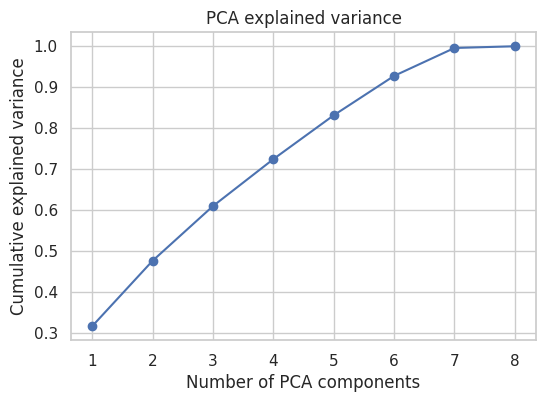

In [ ]:

pca = PCA(n_components=min(10, X_scaled.shape[1]))
pca.fit(X_scaled)
explained = pca.explained_variance_ratio_
print("Explained variance ratio (by component):", explained)
print("Cumulative explained variance:", explained.cumsum())


plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(explained)+1), explained.cumsum(), marker='o')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA explained variance')
plt.grid(True)
plt.show()


Run K-Means + Elbow & Silhouette

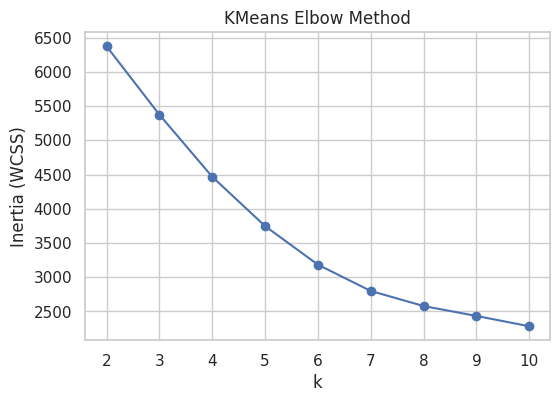

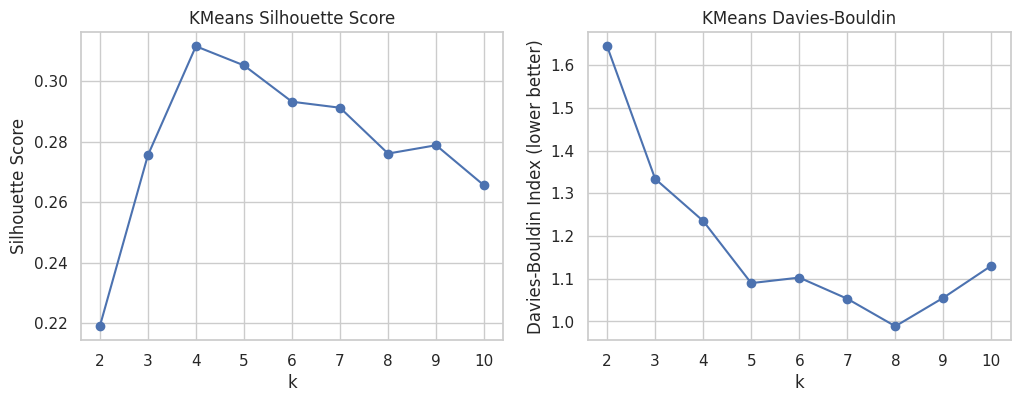

k=2, inertia=6373.89, silhouette=0.219, db=1.644
k=3, inertia=5374.97, silhouette=0.276, db=1.334
k=4, inertia=4467.93, silhouette=0.312, db=1.235
k=5, inertia=3747.29, silhouette=0.305, db=1.090
k=6, inertia=3183.29, silhouette=0.293, db=1.103
k=7, inertia=2799.34, silhouette=0.291, db=1.053
k=8, inertia=2579.13, silhouette=0.276, db=0.989
k=9, inertia=2434.26, silhouette=0.279, db=1.055
k=10, inertia=2283.57, silhouette=0.266, db=1.131


In [ ]:

ks = list(range(2,11))
inertia = []
sil_scores = []
db_scores = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))


plt.figure(figsize=(6,4))
plt.plot(ks, inertia, '-o')
plt.xlabel('k')
plt.ylabel('Inertia (WCSS)')
plt.title('KMeans Elbow Method')
plt.grid(True)
plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ks, sil_scores, '-o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(ks, db_scores, '-o')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin Index (lower better)')
plt.title('KMeans Davies-Bouldin')
plt.grid(True)
plt.show()


for i,k in enumerate(ks):
    print(f"k={k}, inertia={inertia[i]:.2f}, silhouette={sil_scores[i]:.3f}, db={db_scores[i]:.3f}")


Agglomerative (Hierarchical) Clustering + Dendrogram

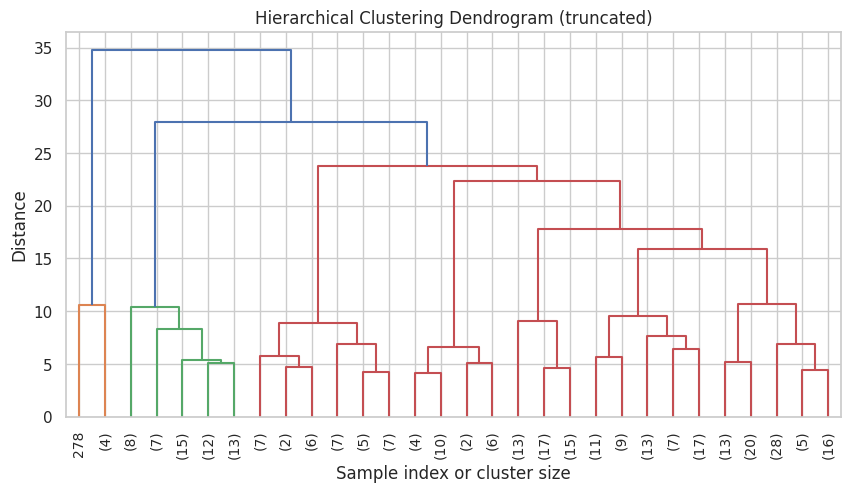

{2: {'silhouette': np.float64(0.19339232208345947),
  'db': np.float64(1.5735311781551906)},
 3: {'silhouette': np.float64(0.24014641073047158),
  'db': np.float64(1.3797538701358014)},
 4: {'silhouette': np.float64(0.27934018882826106),
  'db': np.float64(1.3068589021771435)},
 5: {'silhouette': np.float64(0.2665200122513094),
  'db': np.float64(1.115698085032683)},
 6: {'silhouette': np.float64(0.2698771349079725),
  'db': np.float64(1.1291665395736008)}}

In [ ]:

sample_for_dendro = X_scaled.sample(n=min(300, len(X_scaled)), random_state=42)
linked = linkage(sample_for_dendro, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index or cluster size')
plt.ylabel('Distance')
plt.show()

agg_metrics = {}
for k in [2,3,4,5,6]:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_scaled)
    agg_metrics[k] = {
        'silhouette': silhouette_score(X_scaled, labels),
        'db': davies_bouldin_score(X_scaled, labels)
    }
agg_metrics


DBSCAN (density-based) — optional for outliers

In [ ]:

db_results = {}
for eps in [0.5, 0.8, 1.0, 1.5]:
    for ms in [3,5,8]:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters <= 1:
            continue
        sil = silhouette_score(X_scaled, labels) if n_clusters>1 else np.nan
        db_results[(eps,ms)] = {'n_clusters':n_clusters, 'silhouette':sil}
db_results


{(0.5, 3): {'n_clusters': 47, 'silhouette': np.float64(-0.1776856781606228)},
 (0.5, 5): {'n_clusters': 22, 'silhouette': np.float64(-0.2072723814345698)},
 (0.5, 8): {'n_clusters': 10, 'silhouette': np.float64(-0.24623210337354887)},
 (0.8, 3): {'n_clusters': 26, 'silhouette': np.float64(0.03184404428721573)},
 (0.8, 5): {'n_clusters': 18, 'silhouette': np.float64(-0.0490941160985588)},
 (0.8, 8): {'n_clusters': 11, 'silhouette': np.float64(-0.02012043059010582)},
 (1.0, 3): {'n_clusters': 14, 'silhouette': np.float64(0.17744611532351723)},
 (1.0, 5): {'n_clusters': 6, 'silhouette': np.float64(0.20533258948086294)},
 (1.0, 8): {'n_clusters': 5, 'silhouette': np.float64(0.18384221281423938)},
 (1.5, 3): {'n_clusters': 6, 'silhouette': np.float64(0.3084015143765479)},
 (1.5, 5): {'n_clusters': 4, 'silhouette': np.float64(0.31308958635251927)},
 (1.5, 8): {'n_clusters': 4, 'silhouette': np.float64(0.3081603475906895)}}

Gaussian Mixture Model (soft clustering)

In [ ]:

gmm_metrics = {}
for k in range(2,7):
    gm = GaussianMixture(n_components=k, random_state=42)
    gm_labels = gm.fit_predict(X_scaled)
    gmm_metrics[k] = {
        'bic': gm.bic(X_scaled),
        'silhouette': silhouette_score(X_scaled, gm_labels),
        'db': davies_bouldin_score(X_scaled, gm_labels)
    }
gmm_metrics


{2: {'bic': np.float64(5942.535331949699),
  'silhouette': np.float64(0.1796626389825316),
  'db': np.float64(1.9473430585859566)},
 3: {'bic': np.float64(-4699.456350467557),
  'silhouette': np.float64(0.23704274526852195),
  'db': np.float64(1.5075199012063614)},
 4: {'bic': np.float64(-6514.024319319135),
  'silhouette': np.float64(0.1415774682467972),
  'db': np.float64(2.654471358129718)},
 5: {'bic': np.float64(-13806.621149950366),
  'silhouette': np.float64(0.20569088321832402),
  'db': np.float64(1.5705120943234205)},
 6: {'bic': np.float64(-14057.563236931443),
  'silhouette': np.float64(0.18155301160388693),
  'db': np.float64(1.651984319962219)}}

Choose final model (example: choose K from metrics)

In [ ]:

best_idx = np.argmax(sil_scores)
k_opt = ks[best_idx]
print("KMeans best k by silhouette:", k_opt)

kmeans_final = KMeans(n_clusters=k_opt, random_state=42, n_init=50)
kmeans_labels = kmeans_final.fit_predict(X_scaled)


df_fe['cluster_kmeans'] = kmeans_labels


KMeans best k by silhouette: 4


PCA (2 components) + t-SNE for visualization (2D)

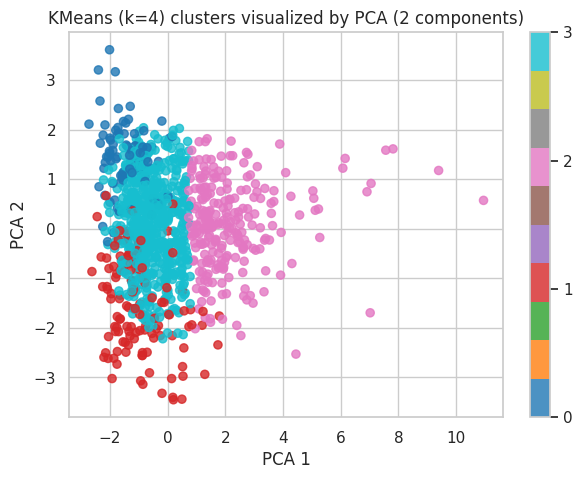

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


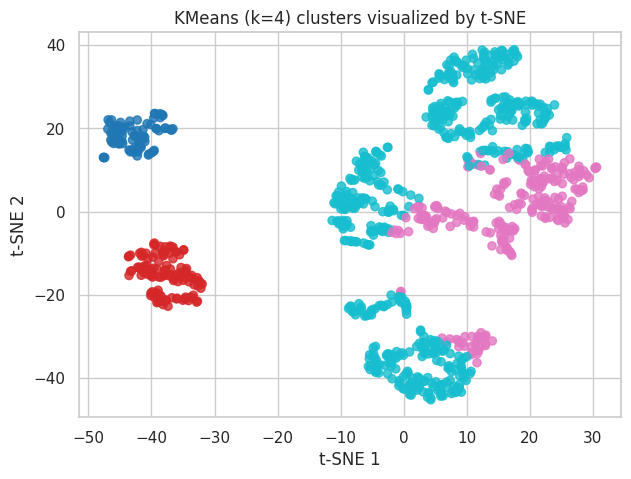

In [ ]:

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
scatter = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=kmeans_labels, cmap='tab10', s=35, alpha=0.8)
plt.xlabel('PCA 1'); plt.ylabel('PCA 2')
plt.title(f'KMeans (k={k_opt}) clusters visualized by PCA (2 components)')
plt.colorbar(scatter, ticks=range(k_opt))
plt.show()


tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmeans_labels, cmap='tab10', s=35, alpha=0.8)
plt.title(f'KMeans (k={k_opt}) clusters visualized by t-SNE')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()


Cluster Profiling (describe each cluster)

In [ ]:

import json
import numpy as np

def cluster_profile(df_original, df_processed, label_col, top_n_brands=5):
    profiles = {}
    clusters = sorted(df_processed[label_col].unique())

    for c in clusters:
        idx = df_processed[df_processed[label_col] == c].index
        cluster_size = len(idx)
        profile = {"size": cluster_size}


        numeric_cols = ['price', 'sold', 'available', 'sales_rate', 'sold_per_price']
        existing_numerics = [n for n in numeric_cols if n in df_original.columns]

        if cluster_size > 0 and existing_numerics:
            stats = (
                df_original.loc[idx, existing_numerics]
                .describe()
                .T[['mean', '50%', 'std']]
                .rename(columns={'50%': 'median'})
                .to_dict()
            )
            profile['numeric_summary'] = stats


        if 'brand' in df_original.columns:
            profile['top_brands'] = df_original.loc[idx, 'brand'].value_counts().head(top_n_brands).to_dict()
        if 'type' in df_original.columns:
            profile['top_types'] = df_original.loc[idx, 'type'].value_counts().head(top_n_brands).to_dict()
        if 'country' in df_original.columns:
            profile['top_countries'] = df_original.loc[idx, 'country'].value_counts().head(top_n_brands).to_dict()

        profiles[int(c)] = profile
    return profiles



profiles = cluster_profile(df, df_fe, 'cluster_kmeans')


profiles_jsonable = {int(k): v for k, v in profiles.items()}


print(json.dumps(profiles_jsonable, indent=2)[:1500])


summary_data = []
for c, p in profiles_jsonable.items():
    avg_price = round(p['numeric_summary'].get('price', {}).get('mean', 0), 2)
    avg_sold = round(p['numeric_summary'].get('sold', {}).get('mean', 0), 2)
    avg_sales_rate = round(p['numeric_summary'].get('sales_rate', {}).get('mean', 0), 3)
    top_brand = next(iter(p.get('top_brands', {})), 'N/A')
    top_type = next(iter(p.get('top_types', {})), 'N/A')
    summary_data.append([c, p['size'], avg_price, avg_sold, avg_sales_rate, top_brand, top_type])

cluster_summary_df = pd.DataFrame(summary_data, columns=[
    'Cluster', 'Size', 'Avg Price', 'Avg Sold', 'Avg Sales Rate', 'Top Brand', 'Top Type'
])

print("\n=== Cluster Summary Table ===")
display(cluster_summary_df)




{
  "0": {
    "size": 88,
    "numeric_summary": {
      "mean": {
        "price": 60.99772727272728,
        "sold": 39.5,
        "available": 7.25
      },
      "median": {
        "price": 49.99,
        "sold": 21.5,
        "available": 8.0
      },
      "std": {
        "price": 37.56029769039952,
        "sold": 61.50133163683083,
        "available": 3.2208016421988495
      }
    },
    "top_brands": {
      "Unbranded": 10,
      "As Show": 10,
      "AS SHOW": 6,
      "Valentino": 6,
      "AS SHOWN": 6
    },
    "top_types": {
      "Eau de Parfum": 39,
      "Eau de Toilette": 35,
      "Perfume": 6,
      "/": 3,
      "Fragrances": 1
    },
    "top_countries": {
      "Hong Kong": 52,
      "Canada": 11,
      "China": 11,
      "Taiwan": 6,
      "India": 3
    }
  },
  "1": {
    "size": 118,
    "numeric_summary": {
      "mean": {
        "price": 41.00745762711864,
        "sold": 78.72881355932203,
        "available": 9.898305084745763
      },
      "medi

,Cluster,Size,Avg Price,Avg Sold,Avg Sales Rate,Top Brand,Top Type
0,0,88,0,0,0,Unbranded,Eau de Parfum
1,1,118,0,0,0,Unbranded,Eau de Parfum
2,2,244,0,0,0,Armaf,Eau de Toilette
3,3,550,0,0,0,Giorgio Armani,Eau de Toilette


Visual summaries of each cluster (boxplots & bar charts)

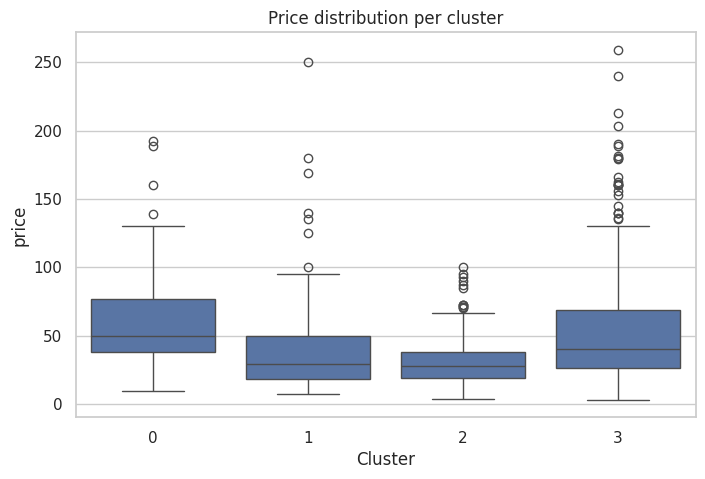

,cluster_kmeans,price,sold,available,sales_rate
2,2,31.130656,2894.885246,50.680328,234.403394
1,1,41.007458,78.728814,9.898305,7.681972
3,3,52.093764,77.905455,8.652727,9.017297
0,0,60.997727,39.500000,7.250000,4.909766


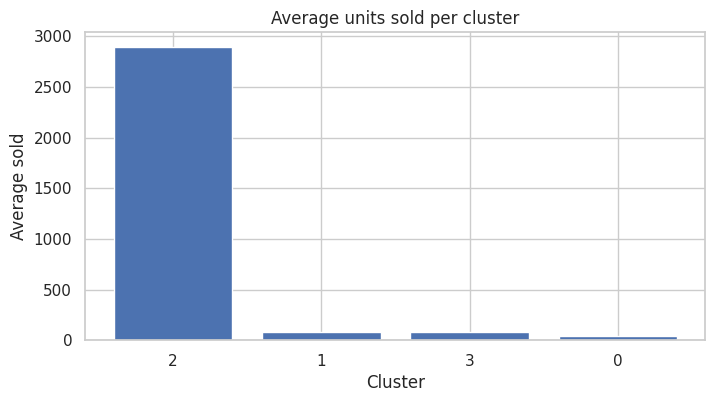

In [ ]:

plt.figure(figsize=(8,5))
sns.boxplot(x='cluster_kmeans', y='price', data=df_fe)
plt.title('Price distribution per cluster')
plt.xlabel('Cluster')
plt.show()


cluster_stats = df_fe.groupby('cluster_kmeans').agg({
    'price':'mean',
    'sold':'mean',
    'available':'mean',
    'sales_rate':'mean'
}).reset_index().sort_values('sold', ascending=False)
display(cluster_stats)

plt.figure(figsize=(8,4))
plt.bar(cluster_stats['cluster_kmeans'].astype(str), cluster_stats['sold'])
plt.title('Average units sold per cluster')
plt.xlabel('Cluster')
plt.ylabel('Average sold')
plt.show()


Save outputs & export labels

In [ ]:

out_fname = 'fragrance_with_clusters.csv'
df_out = df.copy()
df_out['cluster_kmeans'] = df_fe['cluster_kmeans']
df_out.to_csv(out_fname, index=False)
print("Saved", out_fname)


cluster_summary = df_out.groupby('cluster_kmeans').agg({
    'price':'mean','sold':'mean','available':'mean'
}).reset_index()
cluster_summary.to_csv('cluster_summary.csv', index=False)
print("Saved cluster summary CSV")


Saved fragrance_with_clusters.csv
Saved cluster summary CSV


Average Sales per Brand

/tmp/ipython-input-1802497751.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_sales.values, y=avg_sales.index, palette='viridis')


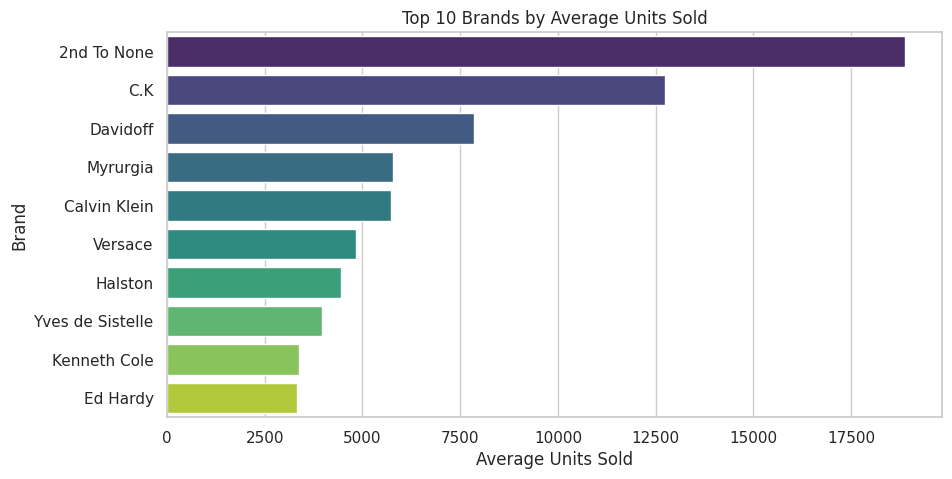

In [ ]:

plt.figure(figsize=(10,5))
avg_sales = df.groupby('brand')['sold'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=avg_sales.values, y=avg_sales.index, palette='viridis')
plt.title("Top 10 Brands by Average Units Sold")
plt.xlabel("Average Units Sold")
plt.ylabel("Brand")
plt.show()


Average Price per Fragrance Type

/tmp/ipython-input-1963932140.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='type', y='price', estimator=np.mean, palette='coolwarm')


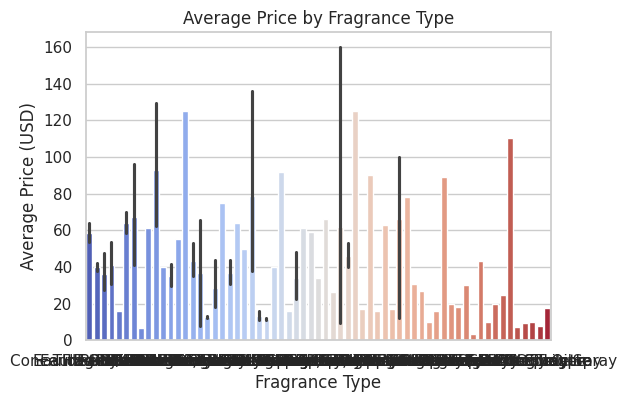

In [ ]:

plt.figure(figsize=(6,4))
sns.barplot(data=df, x='type', y='price', estimator=np.mean, palette='coolwarm')
plt.title("Average Price by Fragrance Type")
plt.xlabel("Fragrance Type")
plt.ylabel("Average Price (USD)")
plt.show()


Average Sales per Cluster (from your K-Means result)

/tmp/ipython-input-3951025995.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_avg_sales, x='cluster_kmeans', y='sold', palette='mako')


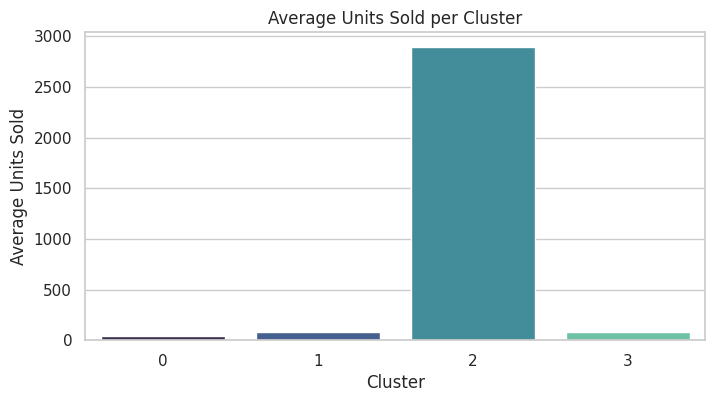

In [ ]:

plt.figure(figsize=(8,4))
cluster_avg_sales = df_fe.groupby('cluster_kmeans')['sold'].mean().reset_index()
sns.barplot(data=cluster_avg_sales, x='cluster_kmeans', y='sold', palette='mako')
plt.title("Average Units Sold per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Units Sold")
plt.show()


Model Comparison: Clustering Techniques Evaluation

=== Model Comparison Table ===


,Model,Clusters,Silhouette Score,Davies-Bouldin Index
0,KMeans (k=4),4,0.5303,0.6732
1,Hierarchical (k=4),4,0.4399,0.8208
2,DBSCAN,2,0.8233,1.1725
3,Gaussian Mixture (k=4),4,-0.0760,2.4551


/tmp/ipython-input-364135636.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


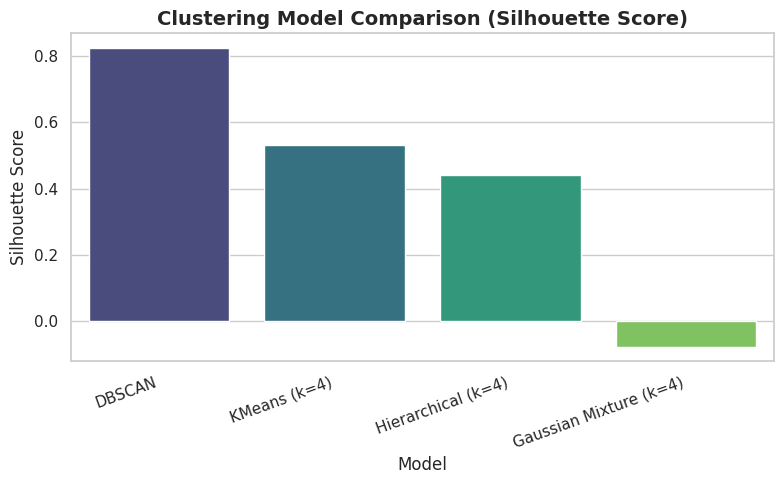

/tmp/ipython-input-364135636.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


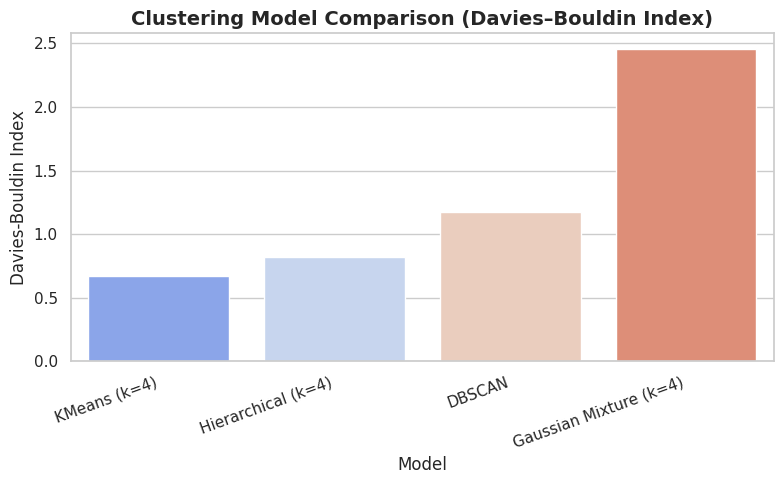

In [23]:

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


features = ['price', 'sold', 'available', 'sales_rate', 'sold_per_price']
X = df_fe[features].copy()


X = X.replace([np.inf, -np.inf], np.nan).dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


models = {
    "KMeans (k=4)": KMeans(n_clusters=4, random_state=42, n_init=10),
    "Hierarchical (k=4)": AgglomerativeClustering(n_clusters=4, linkage='ward'),
    "DBSCAN": DBSCAN(eps=1.2, min_samples=5),
    "Gaussian Mixture (k=4)": GaussianMixture(n_components=4, random_state=42)
}

results = []

for name, model in models.items():

    labels = model.fit_predict(X_scaled)


    if len(set(labels)) > 1 and len(set(labels)) < len(X):
        silhouette = silhouette_score(X_scaled, labels)
        db_index = davies_bouldin_score(X_scaled, labels)
    else:
        silhouette = np.nan
        db_index = np.nan

    results.append({
        "Model": name,
        "Clusters": len(set(labels)),
        "Silhouette Score": round(silhouette, 4),
        "Davies-Bouldin Index": round(db_index, 4)
    })


comparison_df = pd.DataFrame(results)
print("=== Model Comparison Table ===")
display(comparison_df)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(
    data=comparison_df.sort_values("Silhouette Score", ascending=False),
    x="Model", y="Silhouette Score", palette="viridis"
)
plt.title("Clustering Model Comparison (Silhouette Score)", fontsize=14, fontweight='bold')
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(
    data=comparison_df.sort_values("Davies-Bouldin Index", ascending=True),
    x="Model", y="Davies-Bouldin Index", palette="coolwarm"
)
plt.title("Clustering Model Comparison (Davies–Bouldin Index)", fontsize=14, fontweight='bold')
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()
